# Data Science Project : Movie Recommendation System

## Team Members: Ahmad Zeidan , Mosab Abu Laila, Mohammad Hamayel

### Modeling(NearestNeighbors, Neural Networks)

###### Importing Libraries

In [93]:
import pandas as pd
import plotly.express as px
import re
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly as py
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from flask import Flask, request, jsonify
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

from tensorflow.python.keras.layers import Input, Dense, Embedding
from tensorflow.keras.models import Model

from tensorflow import keras

###### Reading MovieLens dataset 

In [94]:
ratings = pd.read_csv('./ml-25m/ratings.csv')

In [95]:
movies = pd.read_csv('./ml-25m/updated_movies.csv')

In [96]:
ratings_df=ratings.copy()

In [97]:
movies_df=movies.copy()

In [98]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [99]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


###### Removing Noise from the data In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.
So with all that taken into account and some trial and error experimentations, we will reduce the noise by adding some filters for the final dataset.
To qualify a movie, a minimum of 100 users should have voted a movie. To qualify a user, a minimum of 50 movies should have voted by the user.

In [100]:
no_user_voted = ratings_df.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings_df.groupby('userId')['rating'].agg('count')

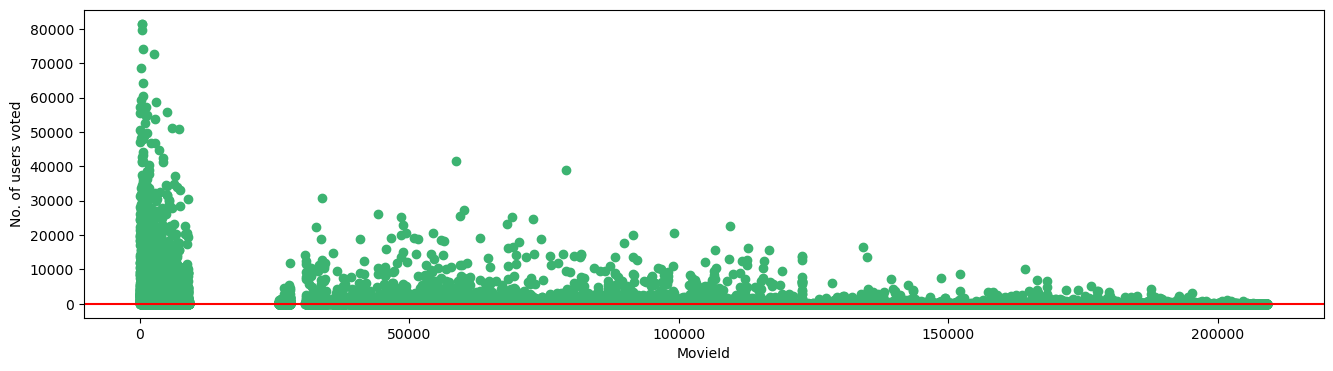

In [101]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

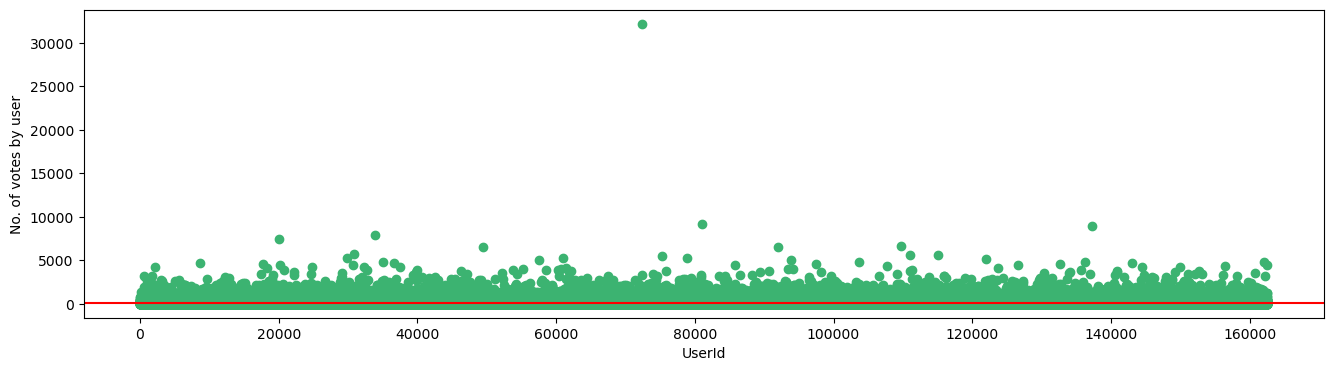

In [102]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [103]:
Qualified_Ratting=ratings_df.loc[ratings['movieId'].isin (no_user_voted[no_user_voted > 2000].index)]

In [104]:
Qualified_Movie_Ratting=Qualified_Ratting.loc[Qualified_Ratting['userId'].isin(no_movies_voted[no_movies_voted > 50].index)]

In [105]:
merged_dataset = pd.merge(Qualified_Movie_Ratting, movies_df, how='inner', on='movieId')
merged_dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,8,296,5.0,890489713,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [106]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()
     

,userId,title,rating
0,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5
1,1,Back to the Future Part II (1989),2.5
2,1,Back to the Future Part III (1990),2.5
3,1,"Bridge on the River Kwai, The (1957)",4.0
4,1,City of God (Cidade de Deus) (2002),5.0


# KNN model to build item-based collaborative Recommender System

##### Movie Recommendation using KNN with Input as User id, Number of similar users should the model pick and Number of movies you want to get recommended

In [79]:

# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(
    index='userId',
     columns='title',
      values='rating').fillna(0)

user_to_movie_df.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,3.5,0.0,0.0,3.5,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<101074x2427 sparse matrix of type '<class 'numpy.float64'>'
	with 18393852 stored elements in Compressed Sparse Row format>

###### Fitting K-Nearest Neighbours model to the scipy sparse matrix

###### param_grid = {
    'n_neighbors': [3,5,10],
    'metric': ['cosine','jaccard'],
    'algorithm': ['brute']
}

knn_model = NearestNeighbors()
grid_search = GridSearchCV(knn_model, param_grid, scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
grid_search.fit(user_to_movie_sparse_df)

# Get the best hyperparameters from the grid search
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_algorithm=grid_search.best_params_['algorithm']

###### print(f"Optimal number of neighbors (n_neighbors): {best_k}")
print(f"Optimal similarity metric: {best_metric}")
print(f"Optimal algorithm: {best_algorithm}")

###### UserToMovie_knn_model = NearestNeighbors(n_neighbors=best_k, metric=best_metric, algorithm=best_algorithm, n_jobs=-1)
UserToMovie_knn_model.fit(user_to_movie_sparse_df)

###### joblib.dump(UserToMovie_knn_model, './movie_recommendation_model.pkl')

In [113]:
UserToMovie_knn_model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute', n_jobs=-1)
UserToMovie_knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [114]:
joblib.dump(UserToMovie_knn_model, './movie_recommendation_model.pkl')

['./movie_recommendation_model.pkl']

In [115]:
def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):
    Knnmodel = joblib.load('./movie_recommendation_model.pkl')
    knn_input = np.asarray([user_to_movie_df.values[user-1]])
    
    distances, indices = Knnmodel.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


  def filtered_movie_recommendations(n = 10):
  
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['userId'] == user_id]['title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [116]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)

Enter user id
1051
number of similar users to be considered
10
Enter number of movies to be recommended:
10
Movie seen by the User:
[]

Top 10 users who are very much similar to the User- 1051 are: 
 
1 . User: 47945 separated by distance of 0.5814048130697131
2 . User: 79804 separated by distance of 0.6218093113774101
3 . User: 19670 separated by distance of 0.6728856623928263
4 . User: 39056 separated by distance of 0.6744961742235103
5 . User: 3817 separated by distance of 0.6828779908140148
6 . User: 1730 separated by distance of 0.6865124886520981
7 . User: 95550 separated by distance of 0.6907796268350457
8 . User: 70628 separated by distance of 0.6937030881061683
9 . User: 15209 separated by distance of 0.6971584512340585
10 . User: 67314 separated by distance of 0.6984835421847795


Movies recommended based on similar users are: 

['Pulp Fiction (1994)',
 'Jurassic Park (1993)',
 'Shawshank Redemption, The (1994)',
 'Godfather, The (1972)',
 'Silence of the Lambs, The (1991)',


###### Movie Recommendation using KNN with Input as Movie Name and Number of movies you want to get recommended:

In [117]:
movie_to_user_df = refined_dataset.pivot(
     index='title',
   columns='userId',
      values='rating').fillna(0)

movie_to_user_df.head()

userId,1,2,3,4,5,8,9,10,12,13,...,162530,162532,162533,162534,162535,162536,162537,162538,162540,162541
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,...,0.0,0.0,2.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0
"10,000 BC (2008)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [118]:

# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df

<2427x101074 sparse matrix of type '<class 'numpy.float64'>'
	with 18393852 stored elements in Compressed Sparse Row format>

In [119]:
#Extracting movie names into a list:
movies_list = list(movie_to_user_df.index)

In [120]:
#Creating a dictionary with movie name as key and its index from the list as value:
movie_dict = {movie : index for index, movie in enumerate(movies_list)}
print(movie_dict)

{"'burbs, The (1989)": 0, '(500) Days of Summer (2009)': 1, '10 Cloverfield Lane (2016)': 2, '10 Things I Hate About You (1999)': 3, '10,000 BC (2008)': 4, '101 Dalmatians (1996)': 5, '101 Dalmatians (One Hundred and One Dalmatians) (1961)': 6, '12 Angry Men (1957)': 7, '12 Years a Slave (2013)': 8, '127 Hours (2010)': 9, '13 Going on 30 (2004)': 10, '13th Warrior, The (1999)': 11, '1408 (2007)': 12, '16 Blocks (2006)': 13, '17 Again (2009)': 14, '1984 (Nineteen Eighty-Four) (1984)': 15, '2 Days in the Valley (1996)': 16, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)': 17, '20,000 Leagues Under the Sea (1954)': 18, '2001: A Space Odyssey (1968)': 19, '2010: The Year We Make Contact (1984)': 20, '2012 (2009)': 21, '21 (2008)': 22, '21 Grams (2003)': 23, '21 Jump Street (2012)': 24, '22 Jump Street (2014)': 25, '25th Hour (2002)': 26, '27 Dresses (2008)': 27, '28 Days (2000)': 28, '28 Days Later (2002)': 29, '28 Weeks Later (2007)': 30, '30 Days of Night (2007)': 31, '300 (2007)

In [121]:

case_insensitive_movies_list = [i.lower() for i in movies_list]

###### param_grid_movie = {
    'n_neighbors': [3,5,10],
    'metric': ['cosine','jaccard'],
    'algorithm': ['brute']
}

knn_model_movie = NearestNeighbors()
grid_search_movie = GridSearchCV(knn_model_movie, param_grid_movie, scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
grid_search_movie.fit(movie_to_user_df)

# Get the best hyperparameters from the grid search
best_k_movie = grid_search_movie.best_params_['n_neighbors']
best_metric_movie = grid_search_movie.best_params_['metric']
best_algorithm_movie=grid_search_movie.best_params_['algorithm']

###### print(f"Optimal number of neighbors (n_neighbors): {best_k_movie}")
print(f"Optimal similarity metric: {best_metric_movie}")
print(f"Optimal algorithm: {best_algorithm_movie}")

###### SimilarMovie_knn_model = NearestNeighbors(n_neighbors=best_k_movie, metric=best_metric_movie, algorithm=best_algorithm_movie, n_jobs=-1)
SimilarMovie_knn_model.fit(user_to_movie_sparse_df)

###### joblib.dump(SimilarMovie_knn_model, './similarmovie_recommendation_model.pkl')

In [124]:

SimilarMovie_knn_model = NearestNeighbors(n_neighbors=10,metric='cosine', algorithm='brute')
SimilarMovie_knn_model.fit(movie_to_user_sparse_df)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [125]:
 joblib.dump(SimilarMovie_knn_model, './similarmovie_recommendation_model.pkl')

['./similarmovie_recommendation_model.pkl']

In [126]:

## function to find top n similar users of the given input user 
def get_similar_movies(movie, n = 10):
    knn_movie_model = joblib.load('./similarmovie_recommendation_model.pkl')
    ## input to this function is the movie and number of top similar movies you want
    index = movie_dict[movie]
    print(index)
    knn_input = np.asarray([movie_to_user_df.values[index]])
    print(knn_input)
    n = min(len(movies_list)-1,n)
    distances, indices = knn_movie_modelX.kneighbors(knn_input, n_neighbors=n+1)
    print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(movies_list[indices[0][i]])

In [127]:
from pprint import pprint
movie_name = '10 Things I Hate About You (1999)'

get_similar_movies(movie_name,15)

3
[[0.  0.  0.  ... 4.5 0.  0. ]]
Top 15 movies which are very much similar to the Movie- 10 Things I Hate About You (1999) are: 
 
Never Been Kissed (1999)
She's All That (1999)
Legally Blonde (2001)
American Pie (1999)
Cruel Intentions (1999)
Wedding Singer, The (1998)
Miss Congeniality (2000)
Big Daddy (1999)
Notting Hill (1999)
Mean Girls (2004)
Bridget Jones's Diary (2001)
Bring It On (2000)
50 First Dates (2004)
How to Lose a Guy in 10 Days (2003)
You've Got Mail (1998)


###### Observation on above built KNN Recommender System:

An interesting observation would be that the above KNN model for movies recommends movies that are produced in very similar years of the input movie. However, the cosine distance of all those recommendations are observed to be actually quite small. This might be because there are too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart.

Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [128]:

# calcuate total number of entries in the movie-user matrix
num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))
     

There is about 92.50% of ratings in our data is missing


###### This result confirms the above hypothesis. The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

# Neural Networks
Google Colab Used in Taining Model

###### Encoding users and movie titles to make sure that the sequence has no missing values when dealing with  Neural Networks.

In [110]:
refined_dataset_nn=refined_dataset.copy()

In [111]:

user_enc = LabelEncoder()
refined_dataset_nn['user'] = user_enc.fit_transform(refined_dataset_nn['userId'].values)
n_users = refined_dataset_nn['user'].nunique()

In [112]:
item_enc = LabelEncoder()
refined_dataset_nn['movie'] = item_enc.fit_transform(refined_dataset_nn['title'].values)
n_movies = refined_dataset_nn['movie'].nunique()

In [113]:

refined_dataset_nn['rating'] = refined_dataset_nn['rating'].values.astype(np.float32)
min_rating = min(refined_dataset_nn['rating'])
max_rating = max(refined_dataset_nn['rating'])
n_users, n_movies, min_rating, max_rating

(101074, 2427, 0.5, 5.0)

In [114]:

refined_dataset_nn.head()

,userId,title,rating,user,movie
0,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.5,0,106
1,1,Back to the Future Part II (1989),2.5,0,192
2,1,Back to the Future Part III (1990),2.5,0,193
3,1,"Bridge on the River Kwai, The (1957)",4.0,0,342
4,1,City of God (Cidade de Deus) (2002),5.0,0,441


In [115]:

X = refined_dataset_nn[['user', 'movie']].values
y = refined_dataset_nn['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16554466, 2), (1839386, 2), (16554466,), (1839386,))

###### Defining number of factors which are to be considered by the Embedding layer

In [116]:

n_factors = 150

In [117]:

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [118]:

X_train, X_train_array, X_train_array[0].shape

(array([[91524,  1424],
        [33798,  1240],
        [ 7041,  1255],
        ...,
        [35929,  1858],
        [98424,   851],
        [56776,   316]]),
 [array([91524, 33798,  7041, ..., 35929, 98424, 56776]),
  array([1424, 1240, 1255, ..., 1858,  851,  316])],
 (16554466,))

###### Normalizing the labels

In [119]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

###### Building a Softmax Deep Neural Network

In [124]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Flatten()(keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user))
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Flatten()(keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie))
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
recmodel = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
recmodel.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [125]:
recmodel.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_26 (Embedding)    (None, 1, 150)               1516110   ['input_39[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_27 (Embedding)    (None, 1, 150)               364050    ['input_40[0][0]']     

In [126]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = recmodel.fit(x = X_train_array, y = y_train, batch_size=8000, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70
2070/2070 [==============================] - 244s 117ms/step - loss: 0.5188 - accuracy: 0.0131 - val_loss: 0.4254 - val_accuracy: 0.0129 - lr: 0.0100
Epoch 2/70
2070/2070 [==============================] - 254s 123ms/step - loss: 0.4286 - accuracy: 0.0130 - val_loss: 0.4233 - val_accuracy: 0.0129 - lr: 0.0100
Epoch 3/70
2070/2070 [==============================] - 245s 118ms/step - loss: 0.4260 - accuracy: 0.0130 - val_loss: 0.4224 - val_accuracy: 0.0129 - lr: 0.0100
Epoch 4/70
2070/2070 [==============================] - 244s 118ms/step - loss: 0.4246 - accuracy: 0.0130 - val_loss: 0.4217 - val_accuracy: 0.0129 - lr: 0.0100
Epoch 5/70
2070/2070 [==============================] - 246s 119ms/step - loss: 0.4235 - accuracy: 0.0130 - val_loss: 0.4209 - val_accuracy: 0.0129 - lr: 0.0100
Epoch 6/70
2070/2070 [==============================] - 248s 120ms/step - loss: 0.4225 - accuracy: 0.0130 - val_loss: 0.4199 - val_accuracy: 0.0129 - lr: 0.0100
Epoch 7/70
2070/2070 [============

Epoch 52/70
2070/2070 [==============================] - 246s 119ms/step - loss: 0.3391 - accuracy: 0.0383 - val_loss: 0.3326 - val_accuracy: 0.0362 - lr: 0.0100
Epoch 53/70
2070/2070 [==============================] - 245s 118ms/step - loss: 0.3372 - accuracy: 0.0398 - val_loss: 0.3313 - val_accuracy: 0.0360 - lr: 0.0100
Epoch 54/70
2070/2070 [==============================] - 246s 119ms/step - loss: 0.3356 - accuracy: 0.0410 - val_loss: 0.3297 - val_accuracy: 0.0380 - lr: 0.0100
Epoch 55/70
2070/2070 [==============================] - 245s 119ms/step - loss: 0.3342 - accuracy: 0.0420 - val_loss: 0.3285 - val_accuracy: 0.0404 - lr: 0.0100
Epoch 56/70
2070/2070 [==============================] - 248s 120ms/step - loss: 0.3329 - accuracy: 0.0429 - val_loss: 0.3275 - val_accuracy: 0.0404 - lr: 0.0100
Epoch 57/70
2070/2070 [==============================] - 247s 119ms/step - loss: 0.3317 - accuracy: 0.0436 - val_loss: 0.3266 - val_accuracy: 0.0419 - lr: 0.0100
Epoch 58/70
2070/2070 [=====

In [127]:
recmodel.save('./RecomendationModel.keras')

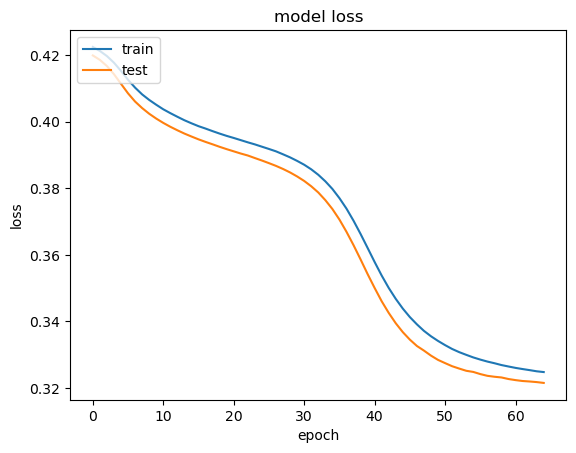

In [128]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

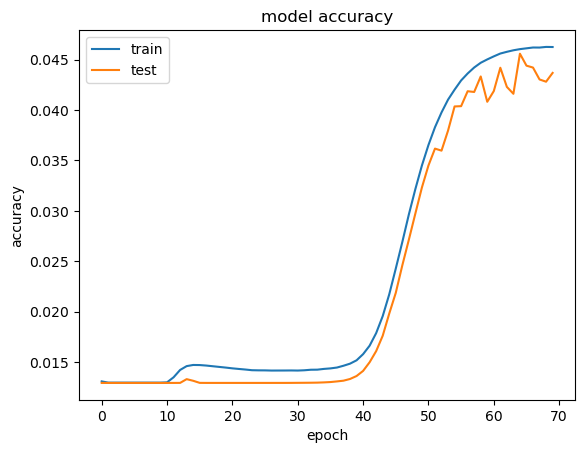

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
import pickle

In [145]:
with open('./trainHistoryRec', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [146]:
with open('./trainHistoryRec', "rb") as file_pi:
    historyrec = pickle.load(file_pi)

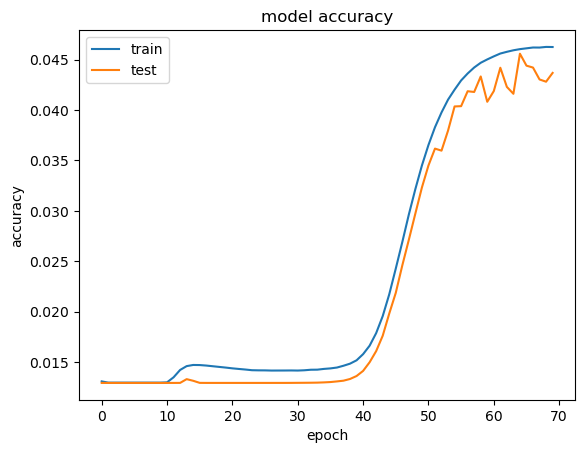

In [148]:
plt.plot(historyrec['accuracy'])
plt.plot(historyrec['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

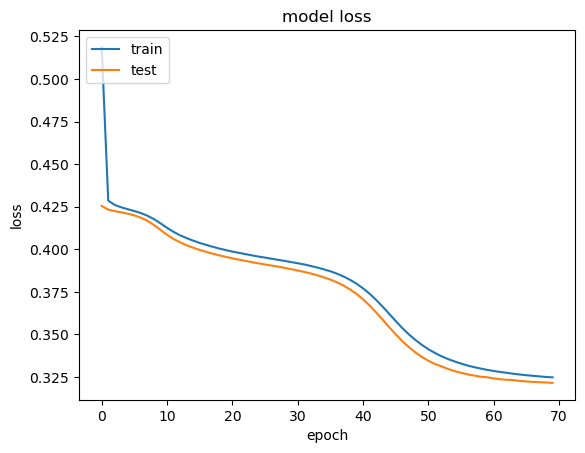

In [149]:
plt.plot(historyrec['loss'])
plt.plot(historyrec['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [170]:
#pip install pyyaml h5py  # Required to save models in HDF5 format

Note: you may need to restart the kernel to use updated packages.


In [129]:
def recommender_system(user_id, model, n_movies):
    rec_model=keras.models.load_model('./RecomendationModel.keras')
    print("")
    print("Movie seen by the User:")
    pprint(list(refined_dataset_nn[refined_dataset_nn['userId'] == user_id]['title']))
    print("")
    encoded_user_id = user_enc.transform([user_id])
    seen_movies = list(refined_dataset_nn[refined_dataset_nn['userId'] == user_id]['movie'])
    unseen_movies = [i for i in range(min(refined_dataset_nn['movie']), max(refined_dataset_nn['movie'])+1) if i not in seen_movies]
    model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
    predicted_ratings = rec_model.predict(model_input)
    predicted_ratings = np.max(predicted_ratings, axis=1)
    sorted_index = np.argsort(predicted_ratings)[::-1]
    recommended_movies = item_enc.inverse_transform(sorted_index)
    print("---------------------------------------------------------------------------------")
    print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
    pprint(list(recommended_movies[:n_movies]))

In [130]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
169
Enter number of movies to be recommended:
10

Movie seen by the User:
['10 Things I Hate About You (1999)',
 '17 Again (2009)',
 '21 (2008)',
 '27 Dresses (2008)',
 '40-Year-Old Virgin, The (2005)',
 '50 First Dates (2004)',
 '8 Mile (2002)',
 'About a Boy (2002)',
 'Across the Universe (2007)',
 'Adventures in Babysitting (1987)',
 'Aladdin (1992)',
 'Almost Famous (2000)',
 'Amadeus (1984)',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 "America's Sweethearts (2001)",
 'American Beauty (1999)',
 'American Gangster (2007)',
 'American History X (1998)',
 'American Pie (1999)',
 'And Your Mother Too (Y tu mamá también) (2001)',
 'Anger Management (2003)',
 'As Good as It Gets (1997)',
 'Babe (1995)',
 'Babel (2006)',
 'Batman Begins (2005)',
 'Beautiful Girls (1996)',
 'Best in Show (2000)',
 'Birdcage, The (1996)',
 'Blade Runner (1982)',
 'Blades of Glory (2007)',
 'Blow (2001)',
 'Bodyguard, The (1992)',
 'Bourne Identity, The (2002)',
 'Bourne Ultimatu

##### Build a Function to Retrive Top Rated Movies 

In [106]:
def get_top_10_rated_movies():
    # Load the MovieLens 25K dataset (or your dataset)
    data = pd.read_csv('./ml-25m/ratings.csv')

    # Group the data by movie ID and calculate the mean rating for each movie
    movie_ratings = data.groupby('movieId')['rating'].mean().reset_index()

    # Sort the movies by mean rating in descending order
    top_rated_movies = movie_ratings.sort_values(by='rating', ascending=False)

    # Get the top 10 rated movies
    top_10_movies = top_rated_movies.head(10)

    # Merge with movie titles to get movie names
    movies = pd.read_csv('./ml-25m/movies.csv')
    top_10_movies_with_titles = top_10_movies.merge(movies, on='movieId', how='left')

    # Return the top 10 rated movies as a DataFrame
    return top_10_movies_with_titles[['movieId', 'title', 'rating']]

In [107]:
top_10_movies = get_top_10_rated_movies()
print(top_10_movies)

   movieId                          title  rating
0   136782  The Girl is in Trouble (2015)     5.0
1   186119            A Gift Horse (2015)     5.0
2   137032    The Perfect Neighbor (2005)     5.0
3   184643              Relentless (2018)     5.0
4   137038        The Perfect Wife (2001)     5.0
5   197231              The Harrow (2016)     5.0
6   184669         Devil's Whisper (2017)     5.0
7   137048           Perfect Child (2007)     5.0
8   137050               The Rival (2006)     5.0
9   137052       A Job to Kill For (2006)     5.0


###### Build a Function to Retrive New Movies

In [108]:
def CleaningMovieProductionDate(x):
    '''
    Function to clean up extra parenthesis at the beginning and end of the string.
    '''
    return (x.str.strip('()'))

In [109]:
def get_newest_n_movies(NumberOfMovies):
    # Load the movies dataset
    movies = pd.read_csv('./ml-25m/movies.csv')
    movies['year'] = movies['title'].str.extract('(\(\d{4}\))').apply(CleaningMovieProductionDate)
    # converting year string to datetime 'year' values
    movies['year'] = pd.to_datetime(movies['year'] , format='%Y')
    # Dropping such records with no Year informationa on them
    movies.dropna(subset=['year'] , inplace=True)
    # Converting year column from datetime to Year 
    movies['year'] = movies['year'].dt.year

    # Sort movies by release year in descending order
    newest_movies = movies.sort_values(by='year', ascending=False)

    # Get the top 10 newest movies
    top_10_newest_movies = newest_movies.head(NumberOfMovies)

    return top_10_newest_movies

In [110]:
# Call the function to get the newest 10 movies
top_10_newest_movies = get_newest_n_movies(10)
print(top_10_newest_movies)

top_10_newest_movies.head(10)

       movieId                                    title  \
61623   206393                           Promare (2019)   
59380   200732                        Native Son (2019)   
60322   203024                      Playing Hard (2019)   
60323   203026                         Mollywood (2019)   
59383   200740                       Antiquities (2019)   
59381   200736                  J'veux du soleil (2019)   
61547   206194    Fiddler: A Miracle of Miracles (2019)   
25068   122914  Avengers: Infinity War - Part II (2019)   
60327   203034            The River and the Wall (2019)   
60329   203038                    The Final Land (2019)   

                        genres  year  
61623  Action|Animation|Sci-Fi  2019  
59380                    Drama  2019  
60322                    Drama  2019  
60323          Horror|Thriller  2019  
59383                   Comedy  2019  
59381              Documentary  2019  
61547              Documentary  2019  
25068  Action|Adventure|Sci-Fi  2019  

,movieId,title,genres,year
61623,206393,Promare (2019),Action|Animation|Sci-Fi,2019
59380,200732,Native Son (2019),Drama,2019
60322,203024,Playing Hard (2019),Drama,2019
60323,203026,Mollywood (2019),Horror|Thriller,2019
59383,200740,Antiquities (2019),Comedy,2019
59381,200736,J'veux du soleil (2019),Documentary,2019
61547,206194,Fiddler: A Miracle of Miracles (2019),Documentary,2019
25068,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi,2019
60327,203034,The River and the Wall (2019),Documentary,2019
60329,203038,The Final Land (2019),Drama|Sci-Fi,2019
